In [1]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os
import tensorflow
from tensorflow.python.client import device_lib
import time
#print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tensorflow.test.is_gpu_available()


Using TensorFlow backend.


True

## Load from keras.datasets.cifar10

In [2]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

170500096/170498071 [==============================] - 6s 0us/step


## Preprocessing

In [3]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)
print('train:', x_train.shape, y_train.shape)
print('train:', x_test.shape, y_test.shape)

train: (50000, 3072) (50000, 10)
train: (10000, 3072) (10000, 10)


## Create Model(MLP)
- Add Batch Nomalization Layer befor each DenseLayer

In [21]:
h_list = [512, 256, 128]
drop_list = [0.25, 0.25, 0.25]
def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, reg={'L2':1e-5}, drop = drop_list):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

## HyperParameters

In [22]:
EPOCHS = 100
BATCH_SIZE_LIST = [50]
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
#set optimizer
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)#, momentum=MOMENTUM)

## Create Model (MLP)

In [23]:
def model_train(model=model, optimizer=optimizer, 
                train = (x_train, y_train), valid = (x_test, y_test),
                e=EPOCHS, bs = BATCH_SIZE_LIST[-1] ):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, epochs=e, batch_size=bs, shuffle=True)
    
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    record = {'train_loss':train_loss,
              'valid_loss':valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc}
    return model, record

## Training

In [24]:
start = time.time()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
model , record = model_train(model, optimizer)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 171us/step - loss: 1.9819 - acc: 0.3160 - val_loss: 1.6483 - val_acc: 0.4217
Epoch 2/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.7242 - acc: 0.3906 - val_loss: 1.5932 - val_acc: 0.4440
Epoch 3/100
50000/50000 [==============================] - 7s 149us/step - loss: 1.6642 - acc: 0.4134 - val_loss: 1.5633 - val_acc: 0.4459
Epoch 4/100
50000/50000 [==============================] - 8s 150us/step - loss: 1.6285 - acc: 0.4239 - val_loss: 1.5598 - val_acc: 0.4589
Epoch 5/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.6069 - acc: 0.4312 - val_loss: 1.5503 - val_acc: 0.4575
Epoch 6/100
50000/50000 [==============================] - 7s 149us/step - loss: 1.5947 - acc: 0.4338 - val_loss: 1.5200 - val_acc: 0.4608
Epoch 7/100
50000/50000 [==============================] - 8s 151us/step - loss: 1.5881 - acc: 0.4359 - val_loss: 1.

50000/50000 [==============================] - 7s 145us/step - loss: 1.4154 - acc: 0.5018 - val_loss: 1.4069 - val_acc: 0.5072
Epoch 60/100
50000/50000 [==============================] - 7s 147us/step - loss: 1.4121 - acc: 0.5015 - val_loss: 1.3733 - val_acc: 0.5138
Epoch 61/100
50000/50000 [==============================] - 7s 147us/step - loss: 1.4079 - acc: 0.5034 - val_loss: 1.3901 - val_acc: 0.5048
Epoch 62/100
50000/50000 [==============================] - 8s 151us/step - loss: 1.4053 - acc: 0.5064 - val_loss: 1.3932 - val_acc: 0.5057
Epoch 63/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.4061 - acc: 0.5021 - val_loss: 1.4055 - val_acc: 0.5018
Epoch 64/100
50000/50000 [==============================] - 7s 147us/step - loss: 1.3970 - acc: 0.5067 - val_loss: 1.3795 - val_acc: 0.5189
Epoch 65/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.3909 - acc: 0.5140 - val_loss: 1.3978 - val_acc: 0.5042
Epoch 66/100
50000/50000 [=======

- GPU: 1 mins 42 secs
- CPU: 7 mins 12 secs

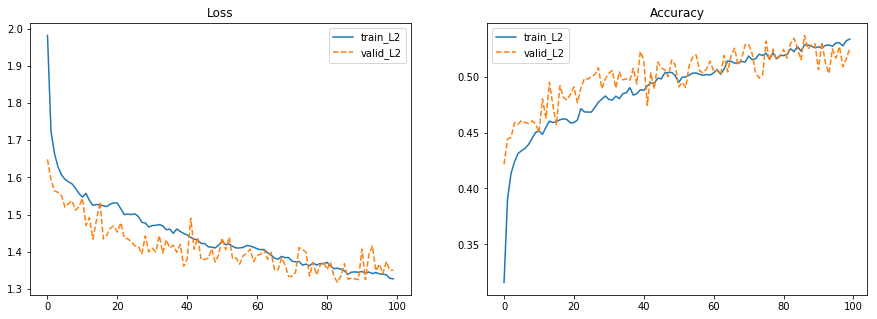

In [25]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()

            
plot_result(record, 'L2', ax1, ax2)
plt.show()

In [26]:
start = time.time()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
model , record = model_train(model, optimizer)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 166us/step - loss: 1.3264 - acc: 0.5328 - val_loss: 1.3409 - val_acc: 0.5255
Epoch 2/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.3236 - acc: 0.5348 - val_loss: 1.3325 - val_acc: 0.5264
Epoch 3/100
50000/50000 [==============================] - 7s 147us/step - loss: 1.3334 - acc: 0.5353 - val_loss: 1.3454 - val_acc: 0.5244
Epoch 4/100
50000/50000 [==============================] - 7s 147us/step - loss: 1.3292 - acc: 0.5342 - val_loss: 1.3610 - val_acc: 0.5170
Epoch 5/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.3276 - acc: 0.5306 - val_loss: 1.3619 - val_acc: 0.5201
Epoch 6/100
50000/50000 [==============================] - 7s 147us/step - loss: 1.3218 - acc: 0.5347 - val_loss: 1.3427 - val_acc: 0.5222
Epoch 7/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.3198 - acc: 0.5362 - val_loss: 1.

50000/50000 [==============================] - 7s 147us/step - loss: 1.2743 - acc: 0.5525 - val_loss: 1.3802 - val_acc: 0.5167
Epoch 60/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.2732 - acc: 0.5529 - val_loss: 1.3338 - val_acc: 0.5314
Epoch 61/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.2747 - acc: 0.5539 - val_loss: 1.3758 - val_acc: 0.5154
Epoch 62/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.2713 - acc: 0.5544 - val_loss: 1.3498 - val_acc: 0.5243
Epoch 63/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.2705 - acc: 0.5535 - val_loss: 1.3406 - val_acc: 0.5261
Epoch 64/100
50000/50000 [==============================] - 7s 146us/step - loss: 1.2616 - acc: 0.5570 - val_loss: 1.3346 - val_acc: 0.5262
Epoch 65/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.2712 - acc: 0.5547 - val_loss: 1.3179 - val_acc: 0.5369
Epoch 66/100
50000/50000 [=======

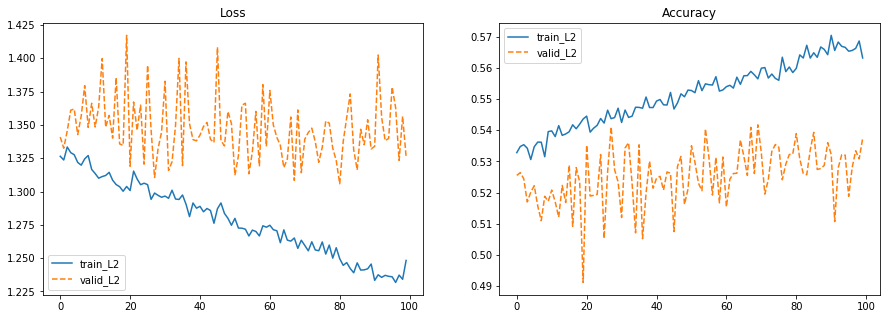

In [27]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()

            
plot_result(record, 'L2', ax1, ax2)
plt.show()